# Фаза 2 • Неделя 8 • Четверг
## Нейронные сети
### Современные сверточные архитектуры

In [ ]:
# Перед выполнением активируем GPU:
# Среда выполнения > Сменить среду выполнения > Аппаратный ускоритель: GPU

In [ ]:
!pip -qq install torchutils

In [ ]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T

# Для чтения изображений с диска
from torchvision import io # input/output
import torchutils as tu
import json
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


In [ ]:
# скачиваем файл с классами ImageNet
# https://www.image-net.org/index.php
!wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
!head imagenet_class_index.json

--2024-10-10 06:53:32--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.172.144, 52.217.120.16, 16.15.193.59, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.172.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K   160KB/s    in 0.2s    

2024-10-10 06:53:34 (160 KB/s) - ‘imagenet_class_index.json’ saved [35363/35363]

{"0": ["n01440764", "tench"], "1": ["n01443537", "goldfish"], "2": ["n01484850", "great_white_shark"], "3": ["n01491361", "tiger_shark"], "4": ["n01494475", "hammerhead"], "5": ["n01496331", "electric_ray"], "6": ["n01498041", "stingray"], "7": ["n01514668", "cock"], "8": ["n01514859", "hen"], "9": ["n01518878", "ostrich"], "10": ["n01530575", "brambling"], "11": ["n01531178", "goldfinch"], "12": ["n01532829

In [ ]:
# делаем словарь, чтобы по индексу найти название класса
labels = json.load(open('imagenet_class_index.json'))
# функция декодировки
decode = lambda x: labels[str(x)][1]
print(decode(0))
print(decode(1))
print(decode(100))
print(decode(220))

tench
goldfish
black_swan
Sussex_spaniel


## Transfer Learning

In [ ]:
# https://pytorch.org/vision/stable/models.html

from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
model = convnext_tiny(weights=ConvNeXt_Tiny_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:01<00:00, 112MB/s] 


In [ ]:
model

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [ ]:
model.to(DEVICE)
fake_batch = torch.randn(4, 3, 224, 224, device=DEVICE)
tu.get_model_summary(model, fake_batch)

Layer                                                    Kernel             Output          Params           FLOPs
0_features.0.Conv2d_0                                  [3, 96, 4, 4]     [4, 96, 56, 56]       4,704    59,006,976
1_features.0.LayerNorm2d_1                                      [96]     [4, 96, 56, 56]         192             0
2_features.1.0.block.Conv2d_0                          [1, 96, 7, 7]     [4, 96, 56, 56]       4,800    60,211,200
3_features.1.0.block.Permute_1                                     -     [4, 56, 56, 96]           0             0
4_features.1.0.block.LayerNorm_2                                [96]     [4, 56, 56, 96]         192             0
5_features.1.0.block.Linear_3                              [96, 384]    [4, 56, 56, 384]      37,248   920,027,136
6_features.1.0.block.GELU_4                                        -    [4, 56, 56, 384]           0             0
7_features.1.0.block.Linear_5                              [384, 96]     [4, 56,

In [ ]:
# скачаем картинку для теста
!wget -q -O image.jpg https://petsi.net/images/dogbreed/big/10.jpg
!wget -q -O image2.jpg https://www.supersadovnik.ru/binfiles/images/20220216/b275afb1.jpg

In [ ]:
# подготовим функцию resize для картинок
resize = T.Resize((224, 224))

In [ ]:
img = resize(io.read_image('image.jpg')/255)
img2 = resize(io.read_image('image2.jpg')/255)

In [ ]:
img2.shape

torch.Size([3, 224, 224])

Форматы массивов-картинок в `matplotlib` и `torch` отличаются, поэтому для визуализации постоянно придется менять положение измерения каналов:
```
matplotlib image format: [224, 224, 3]
torch image format: [3, 224, 224]
```

Это можно легко сделать с помощью функции permute:
```
torch.permute(где менять, (новое положение каналов))
```

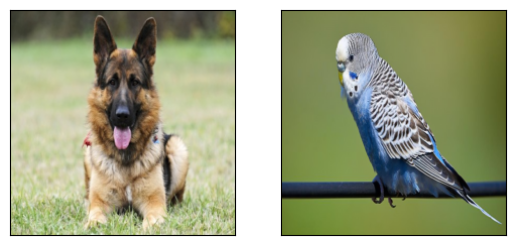

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(torch.permute(img, (1, 2, 0)))
ax[1].imshow(torch.permute(img2, (1, 2, 0)))
[(i.set_xticks([]), i.set_yticks([])) for i in ax];

In [ ]:
print(img.shape)
print(img.unsqueeze(0).shape)

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


In [ ]:
# модель обучалась на формате данных: [batch_size, n_channels, h, w]
# одна картинка это: [n_channels, h, w]
# приводим одну картинку к нужному размеру: [1, n_channels, h, w]

In [ ]:
model(img.to(DEVICE).unsqueeze(0)).argmax().item()

235

In [ ]:
decode(235)

'German_shepherd'

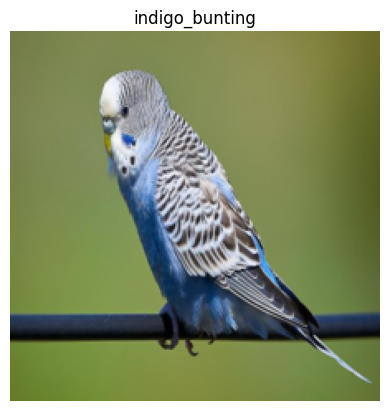

In [ ]:
model.to(DEVICE)
plt.imshow(torch.permute(img2, (1, 2, 0)))
plt.axis('off')
with torch.inference_mode():
    plt.title(decode(model(img2.to(DEVICE).unsqueeze(0)).argmax().item()));

## Fine Tuning

Теперь обучим модель под свою задачу – сделаем **fine-tuning**. Возьмем `resnet18` для скорости – он намного меньше.

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights

model = resnet18(weights=ResNet18_Weights.DEFAULT).to(DEVICE)
tu.get_model_summary(model, fake_batch)

Layer                                       Kernel             Output          Params           FLOPs
0_conv1                                   [3, 64, 7, 7]   [4, 64, 112, 112]       9,408   472,055,808
1_bn1                                              [64]   [4, 64, 112, 112]         128    12,845,056
2_relu                                                -   [4, 64, 112, 112]           0             0
3_maxpool                                             -     [4, 64, 56, 56]           0             0
4_layer1.0.Conv2d_conv1                  [64, 64, 3, 3]     [4, 64, 56, 56]      36,864   462,422,016
5_layer1.0.BatchNorm2d_bn1                         [64]     [4, 64, 56, 56]         128     3,211,264
6_layer1.0.ReLU_relu                                  -     [4, 64, 56, 56]           0             0
7_layer1.0.Conv2d_conv2                  [64, 64, 3, 3]     [4, 64, 56, 56]      36,864   462,422,016
8_layer1.0.BatchNorm2d_bn2                         [64]     [4, 64, 56, 56]       

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Проверяем последний слой
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [ ]:
# Заменяем последний слой на нужный нам
model.fc = nn.Linear(512, 1)

In [ ]:
# Проверяем, заменился ли
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Проверяем, какие параметры обучаемые
for param in model.parameters():
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
for param in model.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [ ]:
# «Размораживаем» те веса, которые будем
# обучать
model.fc.weight.requires_grad = True
model.fc.bias.requires_grad = True

In [ ]:
# Проверяем, True должно встретиться только в самом конце
for param in model.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True


In [ ]:
# Конечно, это можно сделать и с помощью оформления класса
class MyResNet(nn.Module):
    def __init__(self):
        super().__init__()

        # подгружаем модель
        self.model = resnet18(weights=ResNet18_Weights.DEFAULT)
        # заменяем слой
        self.model.fc = nn.Linear(512, 1)
        # замораживаем слои
        for i in self.model.parameters():
            i.requires_grad = False
        # размораживаем только последний, который будем обучать
        self.model.fc.weight.requires_grad = True
        self.model.fc.bias.requires_grad = True

    def forward(self, x):
        return self.model(x)

model = MyResNet()
model.to(DEVICE);

In [ ]:
model

MyResNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [ ]:
# Скачиваем датасет
!wget --no-check-certificate \
https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O cats_and_dogs_filtered.zip

--2024-10-10 07:16:56--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.207, 74.125.130.207, 74.125.68.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  20.2MB/s    in 4.5s    

2024-10-10 07:17:01 (14.6 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
# Распаковываем
!unzip -qq cats_and_dogs_filtered.zip

In [ ]:
# Делаем трансформации, которые подразумевает модель:
# она обучалась на изображениях такого формата
trnsfrms = T.Compose(
    [
        T.Resize((224, 224)),
        T.ToTensor() # автоматически интервал пикселей будет 0-1
    ]
)

In [ ]:
# Про ImageFolder
# читаем тут: https://elbrus-ds-cheatsheets.streamlit.app/PyTorch_Datasets
import torchvision
train_dataset = torchvision.datasets.ImageFolder(
    'cats_and_dogs_filtered/train',
    transform=trnsfrms
)
valid_dataset = torchvision.datasets.ImageFolder(
    'cats_and_dogs_filtered/validation',
    transform=trnsfrms
)

In [ ]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 2000
    Root location: cats_and_dogs_filtered/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [ ]:
train_dataset.class_to_idx

{'cats': 0, 'dogs': 1}

In [ ]:
idx2class= {j: i for i, j in train_dataset.class_to_idx.items()}
idx2class

{0: 'cats', 1: 'dogs'}

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
train_epoch_acc = []
train_epoch_losses = []
valid_epoch_losses = []
valid_epoch_acc =[]
for epoch in range(3):
    model.train()
    loss_batch = []
    acc_batch  = []

    for images, labels in train_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        preds = model(images).squeeze(-1)
        loss = criterion(preds, labels.float())
        loss_batch.append(loss.item())
        accuracy = (preds.sigmoid().round() == labels).cpu().numpy().mean()
        acc_batch.append(accuracy)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_epoch_losses.append(np.mean(loss_batch))
    train_epoch_acc.append(np.mean(acc_batch))

    model.eval()
    loss_batch = []
    acc_batch  = []
    for images, labels in valid_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        with torch.no_grad():
            preds = model(images).squeeze(-1)

        loss = criterion(preds, labels.float())
        loss_batch.append(loss.item())

        accuracy = (preds.sigmoid().round() == labels).cpu().numpy().mean()
        acc_batch.append(accuracy)

    valid_epoch_losses.append(np.mean(loss_batch))
    valid_epoch_acc.append(np.mean(acc_batch))

    print(f'Epoch: {epoch}  loss_train: {train_epoch_losses[-1]:.3f}, loss_valid: {valid_epoch_losses[-1]:.3f}')
    print(f'\t  metrics_train: {train_epoch_acc[-1]:.3f}, metrics_valid: {valid_epoch_acc[-1]:.3f}')

Epoch: 0  loss_train: 0.276, loss_valid: 0.135
	  metrics_train: 0.900, metrics_valid: 0.964
Epoch: 1  loss_train: 0.143, loss_valid: 0.133
	  metrics_train: 0.951, metrics_valid: 0.949
Epoch: 2  loss_train: 0.101, loss_valid: 0.074
	  metrics_train: 0.964, metrics_valid: 0.978


In [ ]:
idx2class

{0: 'cats', 1: 'dogs'}

In [ ]:
torch.sigmoid(model(img.unsqueeze(0).to(DEVICE)))

tensor([[0.9963]], device='cuda:0', grad_fn=<SigmoidBackward0>)

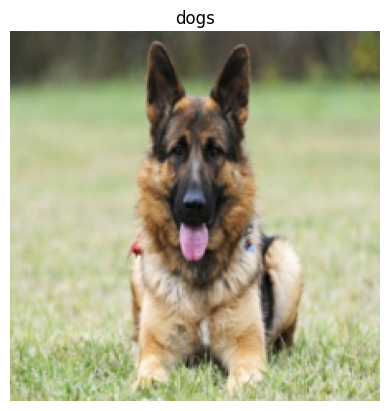

In [ ]:
img = resize(io.read_image('image.jpg')/255)
plt.imshow(torch.permute(img, (1, 2, 0)))
with torch.inference_mode():
    pred_class = torch.sigmoid(model(img.unsqueeze(0).to(DEVICE))).round().item()
plt.axis('off')
plt.title(idx2class[pred_class]);

## Unfreezing example

Теперь возьмем MobileNet (эта модель разрабатывалась специально для мобильных устройств – можно почитать про неё тут: https://telegra.ph/MobileNet-v1-v3-11-24)

In [ ]:
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
mob_model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 114MB/s]


In [ ]:
# Смотрим архитектуру модели, чтобы узнать названия слоев
mob_model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [ ]:
# Добираемся до последнего слоя
mob_model.classifier[3] = nn.Linear(1024, 1)

In [ ]:
mob_model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [ ]:
# Замораживаем все, чтобы разморозить только нужное
for p in mob_model.parameters():
    p.requires_grad = False

In [ ]:
# Unfreeze head layer
## classifier -> (0) Linear
mob_model.classifier[0].weight.requires_grad = True
mob_model.classifier[0].bias.requires_grad = True
## classifier -> (3) Linear
mob_model.classifier[3].weight.requires_grad = True
mob_model.classifier[3].bias.requires_grad = True

# Unfreeze last features layer
## features -> (0) Conv2d
mob_model.features[12][0].weight.requires_grad = True
mob_model.features[12][1].weight.requires_grad = True
mob_model.features[12][1].bias.requires_grad = True

In [ ]:
for param in mob_model.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True


In [ ]:
for p in list(mob_model.parameters())[-10:]:
    print(p.requires_grad)

## Saving and Loading models

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc_1 = nn.Linear(33, 1)
        self.fc_2 = nn.Linear(33, 2)

    def forward(self, x):
        out = self.fc_1(x)
        out = self.fc_2(out)
        return out

In [ ]:
model = Model()

In [ ]:
# fit
# eval
# test

In [ ]:
model.state_dict()

OrderedDict([('fc_1.weight',
              tensor([[ 0.0227,  0.1136, -0.0866,  0.0430,  0.0083, -0.1334,  0.1403,  0.1227,
                       -0.0929,  0.0042, -0.1311,  0.0808, -0.0992, -0.1009, -0.0477, -0.0237,
                       -0.0250,  0.1005, -0.0146, -0.1253, -0.0449,  0.1402,  0.0257,  0.0096,
                       -0.1062, -0.0928,  0.0714, -0.1473,  0.1518,  0.1081,  0.1480,  0.1619,
                       -0.1129]])),
             ('fc_1.bias', tensor([0.0803])),
             ('fc_2.weight',
              tensor([[-0.1323,  0.0147, -0.0850, -0.0103, -0.0205,  0.1216, -0.1073,  0.1660,
                       -0.1730,  0.0032,  0.1019,  0.1479, -0.0664,  0.1189,  0.0306,  0.1615,
                        0.1403,  0.0437,  0.1213,  0.1699,  0.0656,  0.0407, -0.1497,  0.0773,
                        0.1435, -0.1050, -0.0976, -0.1487,  0.0012, -0.0013, -0.0105,  0.0534,
                       -0.1547],
                      [-0.1573, -0.0901,  0.1206, -0.0951, -0.0844,

In [ ]:
torch.save(model.state_dict(), 'weights.pt')

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc_1 = nn.Linear(32, 1)
        self.fc_2 = nn.Linear(33, 2)

    def forward(self, x):
        out = self.fc_1(x)
        out = self.fc_2(out)
        return out

model = Model()

In [ ]:
model.load_state_dict(torch.load('weights.pt'))

RuntimeError: Error(s) in loading state_dict for Model:
	size mismatch for fc_1.weight: copying a param with shape torch.Size([1, 33]) from checkpoint, the shape in current model is torch.Size([1, 32]).

In [ ]:
model.state_dict()

OrderedDict([('fc_1.weight',
              tensor([[ 0.0227,  0.1136, -0.0866,  0.0430,  0.0083, -0.1334,  0.1403,  0.1227,
                       -0.0929,  0.0042, -0.1311,  0.0808, -0.0992, -0.1009, -0.0477, -0.0237,
                       -0.0250,  0.1005, -0.0146, -0.1253, -0.0449,  0.1402,  0.0257,  0.0096,
                       -0.1062, -0.0928,  0.0714, -0.1473,  0.1518,  0.1081,  0.1480,  0.1619,
                       -0.1129]])),
             ('fc_1.bias', tensor([0.0803])),
             ('fc_2.weight',
              tensor([[-0.1323,  0.0147, -0.0850, -0.0103, -0.0205,  0.1216, -0.1073,  0.1660,
                       -0.1730,  0.0032,  0.1019,  0.1479, -0.0664,  0.1189,  0.0306,  0.1615,
                        0.1403,  0.0437,  0.1213,  0.1699,  0.0656,  0.0407, -0.1497,  0.0773,
                        0.1435, -0.1050, -0.0976, -0.1487,  0.0012, -0.0013, -0.0105,  0.0534,
                       -0.1547],
                      [-0.1573, -0.0901,  0.1206, -0.0951, -0.0844,

In [ ]:
def preprocess_model():
    mob_model = mobilenet_v3_small()
    mob_model.classifier[3] = nn.Linear(1024, 1)
    mob_model.load_state_dict(...)
    mob_model.eval()
    return mob_model